Evrişimli sinir ağları görüntülerle çok iyi çalıştığından, onlar hakkında daha fazla bilgi edinmek için bir görüntü veri kümesiyle başlayacağız. Çalışacağımız görseller, 101.001 görselden, 101 farklı kategoriden oluştan [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) veri setindenden alınmıştır.

Başlangıç için, kategorilerden sadece ikisini kullanacağız: pizza ve biftek.

> 🔑 Not: Kullandığımız verileri hazırlamak için görüntüleri farklı alt küme klasörlerine taşıma gibi ön işleme adımları yapılmıştır.

In [1]:
# google drive dosyalarına erişmek için yetki istiyoruz
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# zip şeklinde olan dosyayı unzipliyoruz
import zipfile

# zip'in path adresi
zir_path = "/content/gdrive/MyDrive/Colab Notebooks/TensorFlow Developer Certificate/eğitimler/pizza_steak.zip"
zip_ref = zipfile.ZipFile(zir_path, "r")
zip_ref.extractall()
zip_ref.close()

> Not: Google Colab kullanıyorsanız ve çalışma zamanınızın bağlantısı kesilirse, dosyaları yeniden indirmeniz gerekebilir. Bunu, yukarıdaki hücreyi yeniden çalıştırarak yapabilirsiniz.

## Verileri İnceleyin

Herhangi bir makine öğrenimi projesinin başlangıcında çok önemli bir adım, verilerle bir olmaktır. Bu genellikle, üzerinde çalıştığınız verileri anlamak için bol miktarda görselleştirme ve klasör taraması anlamına gelir. Bunu söylerken, az önce indirdiğimiz verileri inceleyelim.

Dosya yapısı, resimlerle çalışmak için kullanabileceğiniz tipik bir biçimde biçimlendirilmiştir.

Daha spesifik olarak:

Eğitim veri kümesindeki tüm görüntüleri içeren ve her biri o sınıfın görüntülerini içeren belirli bir sınıftan sonra adlandırılan alt dizinleri içeren bir train dizini.

Train dizini ile aynı yapıya sahip bir test dizini.


```
pizza_steak 
└───train 
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test 
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

İndirdiğimiz dizinlerin her birini inceleyelim. Bunu yapmak için, liste anlamına gelen `ls` komutunu kullanabiliriz.


In [3]:
!ls pizza_steak

test  train


Train ve test klasörlerimizi görüyoruz. Bakalım içlerinde ne varmış.

In [4]:
!ls pizza_steak/train/

pizza  steak


Peki ya steak içerisinde ne var?

In [5]:
!ls pizza_steak/train/steak/

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

En sevdiğimiz: Bol bol veri :) Çok görüntü var ama ben yine de bunların kesin bir miktarını istiyorum. Görüntülerin saysısını bulalım.

In [6]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"'{dirpath}' klasöründe {len(filenames)} veri var.")

'pizza_steak' klasöründe 1 veri var.
'pizza_steak/test' klasöründe 1 veri var.
'pizza_steak/test/pizza' klasöründe 250 veri var.
'pizza_steak/test/steak' klasöründe 250 veri var.
'pizza_steak/train' klasöründe 1 veri var.
'pizza_steak/train/pizza' klasöründe 750 veri var.
'pizza_steak/train/steak' klasöründe 750 veri var.


In [7]:
# Bir dosyada kaç tane resim olduğunu bulmanın başka bir yolu
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

In [8]:
# Class adlarını alalım
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['.DS_Store' 'pizza' 'steak']


Pekala, elimizde 750 train görseli ve 250 adet pizza ve biftek görseli içeren bir verisetimiz var.

Bazılarına bakalım.

> 🤔 Not: Verilerle çalışırken, mümkün olduğunca görselleştirmek her zaman iyidir. Bir projenin ilk birkaç adımını verilerle bir bütün olarak ele alın. Görselleştirin, görselleştirin, görselleştirin.

In [9]:
# Bir resmi görüntüleyelim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  # random bir görsel path'i
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


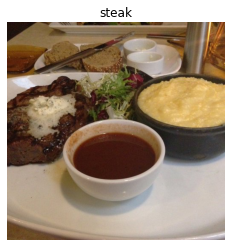

In [10]:
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

Farklı sınıflardan bir düzine kadar görüntüyü inceledikten sonra, neyle çalıştığımız hakkında bir fikir edinmeye başlayabilirsiniz. Food101 veri setinin tamamı, 101 farklı sınıftan benzer görüntülerden oluşuyor. Görüntü şeklini, çizilen görüntünün yanına yazdırdığımızı fark etmiş olabilirsiniz. Bunun nedeni, bilgisayarımızın görüntüyü görme biçiminin büyük bir dizi (tensör) biçiminde olmasıdır.


In [11]:
img

array([[[ 29,  14,   9],
        [ 30,  15,  10],
        [ 31,  16,  11],
        ...,
        [113,  48,  10],
        [110,  48,   0],
        [117,  57,   0]],

       [[ 30,  15,  10],
        [ 32,  17,  12],
        [ 33,  18,  13],
        ...,
        [114,  50,  12],
        [109,  47,   0],
        [125,  64,   7]],

       [[ 30,  15,   8],
        [ 33,  18,  11],
        [ 35,  20,  15],
        ...,
        [117,  54,  13],
        [118,  56,   7],
        [138,  79,  21]],

       ...,

       [[102,  72,  34],
        [107,  77,  39],
        [108,  78,  40],
        ...,
        [138, 126, 130],
        [137, 125, 129],
        [139, 124, 129]],

       [[108,  78,  40],
        [109,  79,  41],
        [108,  79,  39],
        ...,
        [140, 125, 128],
        [142, 127, 130],
        [144, 129, 132]],

       [[105,  75,  37],
        [103,  74,  34],
        [102,  73,  33],
        ...,
        [141, 126, 129],
        [143, 128, 131],
        [146, 131, 134]]

In [12]:
# görüntünün şeklini yazdıralım
img.shape

(512, 512, 3)

Görüntü şekline daha yakından baktığınızda, formda olduğunu göreceksiniz (Genişlik, Yükseklik, Renk Kanalları).

Bizim durumumuzda genişlik ve yükseklik değişkendir ancak renkli görüntülerle uğraştığımız için renk kanalları değeri her zaman 3'tür. Bu, farklı kırmızı, yeşil ve mavi (RGB) piksel değerleri içindir.

img dizisindeki tüm değerlerin 0 ile 255 arasında olduğunu fark edeceksiniz. Bunun nedeni, kırmızı, yeşil ve mavi değerlerin olası aralığının bu olmasıdır.

Örneğin, kırmızı=0, yeşil=0, mavi=255 değerine sahip bir piksel mavi görünecektir.

> 🔑 Not: Daha önce tartıştığımız gibi, sinir ağları dahil birçok makine öğrenimi modeli, birlikte çalıştıkları değerlerin 0 ile 1 arasında olmasını tercih eder. Bunu bilerek, görüntülerle çalışmak için en yaygın ön işleme adımlarından biri ölçeklendirmektir (ayrıca görüntü dizilerini 255'e bölerek piksel değerlerini normalleştirme olarak adlandırılır.

In [13]:
# 0 ve 1 arasındaki tüm piksel değerlerini alın
img/255. 

array([[[0.11372549, 0.05490196, 0.03529412],
        [0.11764706, 0.05882353, 0.03921569],
        [0.12156863, 0.0627451 , 0.04313725],
        ...,
        [0.44313725, 0.18823529, 0.03921569],
        [0.43137255, 0.18823529, 0.        ],
        [0.45882353, 0.22352941, 0.        ]],

       [[0.11764706, 0.05882353, 0.03921569],
        [0.1254902 , 0.06666667, 0.04705882],
        [0.12941176, 0.07058824, 0.05098039],
        ...,
        [0.44705882, 0.19607843, 0.04705882],
        [0.42745098, 0.18431373, 0.        ],
        [0.49019608, 0.25098039, 0.02745098]],

       [[0.11764706, 0.05882353, 0.03137255],
        [0.12941176, 0.07058824, 0.04313725],
        [0.1372549 , 0.07843137, 0.05882353],
        ...,
        [0.45882353, 0.21176471, 0.05098039],
        [0.4627451 , 0.21960784, 0.02745098],
        [0.54117647, 0.30980392, 0.08235294]],

       ...,

       [[0.4       , 0.28235294, 0.13333333],
        [0.41960784, 0.30196078, 0.15294118],
        [0.42352941, 0

## Bir Evrişimsel Sinir Ağının Mimarisi

CNN, birçok farklı şekilde oluşturulabilmeleri nedeniyle diğer derin öğrenme sinir ağlarından farklı değildir. Aşağıda gördükleriniz, geleneksel bir CNN'de bulmayı umduğunuz bazı bileşenlerdir.

Evrişimli bir sinir ağının bileşenleri:
- **Input Image** <br>
Kalıpları keşfetmek istediğiniz görüntüleri hedefleyin
- **Input Layer** <br>
Hedef görüntüleri alır ve daha sonraki katmanlar için önceden işler
- **Convolution Layer** <br>
Hedef görüntülerden en önemli özellikleri çıkarır/öğrenir
- **Hidden Activation** <br>
Öğrenilen özelliklere doğrusal olmayanlara ekler (düz olmayan çizgiler)
- **Pooling layer** <br>
Öğrenilmiş görüntü özelliklerinin boyutsallığını eğitir
- **Fully Connected Layer** <br>
Evrişim katmanlarından öğrenilen özellikleri daha da iyileştirir
- **Output layer** <br>
Öğrenilen özellikleri alır ve bunları hedef etiketler şeklinde verir
- **Output activation** <br>
Çıktı katmanına doğrusal olmayanlar ekler


### Örnek

Verilerimizi inceledik ve sınıf başına 750 train resminin yanı sıra 250 test resmi olduğunu ve hepsinin farklı şekillerde olduğunu gördük.

Doğrudan derinlere atlamanın zamanı geldi.

Orijinal veri seti yazarlarının makalesini okuduğumuzda, bir Random Forest makine öğrenme modeli kullandıklarını ve içlerinde hangi farklı yiyeceklerin farklı görüntülere sahip olduğunu tahmin etmede ortalama %50,76 doğruluk elde ettiklerini görüyoruz.

Şu andan itibaren, bu %50,76 bizim temelimiz olacak.

> 🔑 Not: Temel, denemek ve geçmek istediğiniz bir puan veya değerlendirme metriğidir. Genellikle basit bir modelle başlayacak, bir temel oluşturacak ve modelin karmaşıklığını artırarak onu yenmeye çalışacaksınız. Makine öğrenimini öğrenmenin gerçekten eğlenceli bir yolu, sonuçları yayınlanmış bir tür modeli yenmeye çalışmaktır.

Aşağıdaki hücredeki kod, pizza ve biftek veri setimizi yukarıda listelenen bileşenleri kullanarak bir evrişimsel sinir ağı (CNN) ile modellemek için uçtan uca bir şekilde çoğalır.

Anlamayacağınız yerler olabilir fakat kodu iyice analiz ettiken sonra ne yapmak istediğimi  anlayacağınızdan eminim. 

> 📖 Kaynak: Aşağıda kullandığımız mimari, 2014 ImageNet sınıflandırma yarışmasında 2. olan evrişimli bir sinir ağı olan VGG-16'nın küçültülmüş bir versiyonudur.

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

# Ön işleme verileri (1 ile 0 arasındaki tüm piksel değerlerini alın, 
# ayrıca ölçekleme/normalleştirme olarak da adlandırılır)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Train ve test dizinlerini kurun
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Dizinlerdeki verileri içe aktarın
train_data = train_datagen.flow_from_directory(train_dir,
                                               # bir seferde işlenecek görüntü sayısı
                                               batch_size=32, 
                                               # tüm görüntüleri 224 x 224'e dönüştür
                                               target_size=(224, 224), 
                                               # üzerinde çalıştığımız problemin türü
                                               class_mode="binary", 
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# CNN modeli yaratma (https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3,
                         activation="relu", 
                         input_shape=(224, 224, 3)), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size ayrıca (2, 2) olabilir
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary aktivasyon çıktısı
])

# modeli derleme
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# modeli fit etme
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 41s 199ms/step - loss: 0.5436 - accuracy: 0.7293 - val_loss: 0.4246 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 9s 183ms/step - loss: 0.4145 - accuracy: 0.8100 - val_loss: 0.3396 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 9s 188ms/step - loss: 0.4069 - accuracy: 0.8227 - val_loss: 0.3411 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 9s 186ms/step - loss: 0.3654 - accuracy: 0.8480 - val_loss: 0.3016 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 9s 201ms/step - loss: 0.3343 - accuracy: 0.8620 - val_loss: 0.2961 - val_accuracy: 0.8920


> 🤔 Not: Yukarıdaki hücrenin çalışması epoch başına ~12 saniyeden uzun sürüyorsa GPU hızlandırıcı kullanmıyor olabilirsiniz. Colab dizüstü bilgisayar kullanıyorsanız, Çalışma Zamanı -> Çalışma Zamanı Türünü Değiştir -> Donanım Hızlandırıcı'ya gidip "GPU"yu seçerek bir GPU hızlandırıcıya erişebilirsiniz. Bunu yaptıktan sonra, çalışma zamanı türünü değiştirmek Colab'ın sıfırlanmasına neden olacağından yukarıdaki hücrelerin tümünü yeniden çalıştırmanız gerekebilir.

Güzel! 5 epoch sonra modelimiz %50,76 doğruluk temel puanını geçti (modelimiz train setinde ~%85 doğruluk ve test setinde ~%85 doğruluk elde etti).

Ancak, modelimiz Food101 veri setindeki 101 sınıfın tümü yerine yalnızca ikili sınıflandırma probleminden geçti, bu nedenle bu ölçümleri doğrudan karşılaştıramıyoruz. Bununla birlikte, şu ana kadarki sonuçlar modelimizin bir şeyler öğrendiğini gösteriyor.

> 🛠 Alıştırma: Yukarıdaki hücredeki ana kod bloklarının her birinin üzerinden geçin, her birinin ne yaptığını düşünüyorsunuz? Emin değilseniz sorun değil, bunu yakında halledeceğiz. Bu arada, [CNN açıklayıcı web](https://poloclub.github.io/cnn-explainer/) sitesinde 10 dakika oynayarak vakit geçirin. Web sayfasının üst kısmındaki katman adları hakkında ne fark ediyorsunuz?

Halihazırda bir modeli fit ettiğimize göre, mimarisine bir göz atalım.

In [15]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

Model_1 katmanlarının adları ve CNN açıklayıcı web sitesinin en üstündeki katman adları hakkında ne fark ediyorsunuz?

Size küçük bir sır vereyim: Model demoları için kullandıkları mimariyi aynen kopyaladık.

Şimdi burada anlatmadığımız birkaç yeni şey var:
- **ImageDataGenerator** sınıfı ve yeniden ölçeklendirme parametresi
- **flow_from_directory()** yöntemi
- **batch_size** parametresi
- **target_size** parametresi
- **Conv2D katmanları** (ve bunlarla birlikte gelen parametreler)
- **MaxPool2D katmanları** (ve parametreleri).
- fit() işlevindeki **step_per_epoch** ve **validation_steps** parametreleri

Bunların her birine derinlemesine işlemeden önce, daha önce üzerinde çalıştığımız bir modeli verilerimizle fit etmeye çalışırsak ne olacağını görelim.

## Daha Önce Olduğu Gibi Aynı Modeli Kullanma

Sinir ağlarının birçok farklı soruna nasıl uyarlanabileceğini örneklemek için, daha önce oluşturduğumuz bir ikili sınıflandırma modelinin verilerimizle nasıl çalışabileceğini görelim.

İki şeyi değiştirmek dışında önceki modelimizde aynı parametrelerin hepsini kullanabiliriz:

- **Veriler** <br>
Artık noktalar yerine resimlerle çalışıyoruz.
- **Input Shape** <br>
Sinir ağımıza üzerinde çalıştığımız görüntülerin şeklini söylemeliyiz. <br>
Yaygın bir uygulama, görüntüleri tek bir boyuta yeniden şekillendirmektir. Bizim durumumuzda, görüntüleri (224, 224, 3) olarak yeniden boyutlandıracağız; bu, kırmızı, yeşil, mavi renk kanalları için 224 piksel yükseklik ve genişlik ve 3 derinlik anlamına gelir.

In [16]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# modeli derleme
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#  modeli fit etme
history_2 = model_2.fit(train_data,
                        # yukarıda oluşturulan eğitim verilerinin aynısını kullanıyoruz
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        # yukarıda oluşturulan aynı doğrulama verilerini kullanıyoruz
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 191ms/step - loss: 0.7278 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 9s 186ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 8s 173ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 8s 173ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 8s 173ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


Hmmm... modelimiz çalıştı ama hiçbir şey öğrenmiş gibi görünmüyor.

Mimariyi görelim.


In [17]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Vay. Buradaki en dikkat çekici şeylerden biri, model_2'ye kıyasla model_1'deki çok daha fazla parametre sayısıdır.

model_2, 602.141 eğitilebilir parametreye sahipken, model_1 yalnızca 31.101'e sahiptir. Ve bu farklılığa rağmen, model_1 hala model_2'ye göre daha performanslı sonuç üretir.

> 🔑 Not: Eğitilebilir parametreleri, bir modelin verilerden öğrenebileceği kalıplar olarak düşünebilirsiniz. Sezgisel olarak, daha fazlasının daha iyi olduğunu düşünebilirsiniz. Ve bazı durumlarda öyle. Ancak bu durumda, buradaki fark, kullandığımız iki farklı model stilindedir. Bir dizi yoğun katman birbirine bağlı bir dizi farklı öğrenilebilir parametreye ve dolayısıyla daha fazla sayıda olası öğrenilebilir örüntüye sahip olduğunda, evrişimli bir sinir ağı bir görüntüdeki en önemli örüntüleri ayırmaya ve öğrenmeye çalışır. Dolayısıyla, evrişimli sinir ağımızda daha az öğrenilebilir parametreler olsa da, bunlar genellikle bir görüntüdeki farklı özellikler arasında şifre çözmede daha faydalıdır.

Önceki modelimiz çalışmadığına göre, onu nasıl çalıştırabileceğimize dair bir fikriniz var mı? Katman sayısını artırmaya ne dersiniz? Ve belki de her katmandaki nöron sayısını artırabilir mi?

Daha spesifik olarak, her yoğun katmandaki nöron sayısını (gizli birimler olarak da adlandırılır) 4'ten 100'e çıkaracağız ve fazladan bir katman ekleyeceğiz.

🔑 Not: Fazladan katman eklemek veya her katmandaki nöron sayısını artırmak, genellikle modelinizin karmaşıklığını artırmak olarak adlandırılır.

In [18]:
tf.random.set_seed(42)

# model yaratma
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(100, activation='relu'),# nöron sayısını 4'ten 100'e çıkarıyoruz (her katman için)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # ekstradan bir katman ekliyoruz
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# modeli derleme
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#  modeli fit etme
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 177ms/step - loss: 3.1591 - accuracy: 0.6493 - val_loss: 0.8408 - val_accuracy: 0.7460
Epoch 2/5
47/47 [==============================] - 8s 178ms/step - loss: 0.8990 - accuracy: 0.7253 - val_loss: 1.0033 - val_accuracy: 0.7080
Epoch 3/5
47/47 [==============================] - 9s 186ms/step - loss: 1.1207 - accuracy: 0.7013 - val_loss: 1.0581 - val_accuracy: 0.6400
Epoch 4/5
47/47 [==============================] - 9s 188ms/step - loss: 0.5718 - accuracy: 0.7767 - val_loss: 0.6213 - val_accuracy: 0.7660
Epoch 5/5
47/47 [==============================] - 8s 179ms/step - loss: 0.7869 - accuracy: 0.7393 - val_loss: 0.5097 - val_accuracy: 0.7800


Vay! Görünüşe göre modelimiz yeniden öğreniyor. Eğitim setinde ~%70 doğruluk ve doğrulama setinde ~%70 doğruluk elde etti.

Mimari nasıl görünüyor?

In [19]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Eğitilebilir parametrelerin sayısı model_2'den bile daha fazla arttı. Ve 500 kata yakın (~15.000.000 vs. ~31.000) daha fazla eğitilebilir parametreyle bile, model_3 hala model_1'i geçemiyor.

Bu, evrişimli sinir ağlarının gücünü ve daha az parametre kullanmasına rağmen kalıpları öğrenme yeteneklerini gösteriyor.

## İkili sınıflandırma: Modelde Derinlemesine Çalışalım

1. Verilerle bütünleşin (görselleştirin, görselleştirin, görselleştirin...)
2. Verileri önceden işleyin (bir model için hazırlayın)
3. Bir model oluşturun (bir temel ile başlayın)
4. Modeli fit edin
5. Modeli değerlendirin
6. Farklı parametreleri ayarlayın ve modeli iyileştirin (temel çizginizi geçmeye çalışın)
7. Memnun kalana kadar tekrarlayın

Her birinin üzerinden geçelim.

### 1.Verileri İçe Aktarın ve Verilerle Bütünleşin

Ne tür bir veriyle uğraşırsanız uğraşın, kendi zihinsel veri modelinizi oluşturmaya başlamak için en az 10-100 örneği görselleştirmek iyi bir fikirdir.

Bizim durumumuzda, biftek görüntülerinin daha koyu renklere sahip olma eğiliminde olduğunu, pizza görüntülerinin ise ortada belirgin bir dairesel şekle sahip olma eğiliminde olduğunu fark edebiliriz. Bunlar, sinir ağımızın yakaladığı kalıplar olabilir.

Ayrıca, bazı verilerinizin bozuk olup olmadığını (örneğin, yanlış etikete sahip olup olmadığını) fark eder ve bunları düzeltmek için izleyebileceğiniz yolları düşünmeye başlarsınız.

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


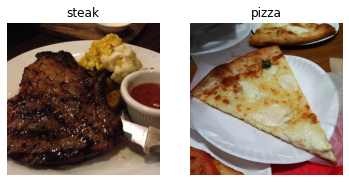

In [20]:
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2.Verileri Önceden İşleyin

Bir makine öğrenimi projesi için en önemli adımlardan biri eğitim ve test seti oluşturmaktır.

Bizim durumumuzda, verilerimiz zaten eğitim ve test setlerine bölünmüştür. Buradaki başka bir seçenek de bir doğrulama seti oluşturmak olabilir, ancak şimdilik bunu bırakacağız.

Bir görüntü sınıflandırma projesi için, verilerinizin her sınıf için her birinde alt klasörler bulunan train ve test dizinlerine ayrılması standarttır.

Başlamak için eğitim ve test dizini yollarını tanımlıyoruz.

In [21]:
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Bir sonraki adımımız, verilerimizi yığınlara dönüştürmektir.

Toplu iş, bir modelin eğitim sırasında baktığı veri kümesinin küçük bir alt kümesidir. Örneğin, bir seferde 10.000 görüntüye bakmak ve kalıpları anlamaya çalışmak yerine, bir model bir seferde yalnızca 32 görüntüye bakabilir.

Bunu birkaç nedenden dolayı yapar:

- 10.000 görüntü (veya daha fazla) işlemcinizin (GPU) belleğine sığmayabilir.
- 10.000 görüntüdeki kalıpları tek bir vuruşta öğrenmeye çalışmak, modelin çok iyi öğrenememesine neden olabilir.

Neden 32?

32'lik bir epoch büyüklüğü sağlığınız için iyidir.

Hayır, gerçekten, kullanabileceğiniz birçok farklı parti boyutu vardır, ancak 32'nin birçok farklı kullanım durumunda çok etkili olduğu kanıtlanmıştır ve çoğu zaman birçok veri ön işleme işlevi için varsayılandır.

Verilerimizi toplu işlere dönüştürmek için önce veri kümelerimizin her biri için bir ImageDataGenerator örneği oluşturacağız.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

ImageDataGenerator sınıfı, görüntülerimizi yığınlar halinde hazırlamamıza ve modele yüklenirken üzerlerinde dönüşümler gerçekleştirmemize yardımcı olur.

Yeniden ölçeklendirme parametresini fark etmiş olabilirsiniz. Bu, yaptığımız dönüşümlerin bir örneğidir.

Daha önce bir görüntüyü nasıl içe aktardığımızı ve piksel değerlerinin 0 ile 255 arasında olduğunu hatırlıyor musunuz?

1/255 ile birlikte yeniden ölçeklendirme parametresi. "tüm piksel değerlerini 255'e böl" demek gibidir. Bu, tüm görüntünün içe aktarılmasıyla ve piksel değerlerinin normalleştirilmesiyle sonuçlanır (0 ile 1 arasında dönüştürülür).

> 🔑 Not: Veri büyütme ve daha fazla dönüştürme seçeneği için (bunu daha sonra göreceğiz), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) belgelerine bakın.

Şimdi birkaç ImageDataGenerator örneğimiz var, görüntülerimizi flow_from_directory yöntemini kullanarak ilgili dizinlerinden yükleyebiliriz.

In [23]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Olağanüstü! Görünüşe göre eğitim veri setimizde 2 sınıfa (pizza ve steak) ait 1500 görüntü var ve test veri setimizde 2 sınıfa ait 500 görüntü var.

Buraya bazı şeyler:

- Dizinlerimizin nasıl yapılandırıldığına bağlı olarak, sınıflar, `train_dir` ve `test_dir` içindeki alt dizin adlarından anlaşılır.
- `target_size` parametresi, resimlerimizin giriş boyutunu (yükseklik, genişlik) biçiminde tanımlar.
- `'binary'`nin class_mode değeri, sınıflandırma problem türümüzü tanımlar. İkiden fazla sınıfımız olsaydı, `'categorical'` kullanırdık.
- `batch_size`, her toplu işte kaç tane resim olacağını tanımlar, biz varsayılanla aynı olan 32'yi kullandık.

Train_data nesnesini inceleyerek toplu resimlerimize ve etiketlerimize göz atabiliriz.

In [24]:
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

Harika, görünüşe göre resimlerimiz ve etiketlerimiz 32'lik gruplar halinde.

Bakalım resimler nasıl görünüyor.

In [25]:
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

Yeniden ölçeklendirme parametremiz nedeniyle, görüntüler artık 0 ile 1 arasında değerlere sahip (224, 224, 3) şekil tensörlerindedir.

Peki ya etiketler?


In [26]:
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

`class_mode` parametresinin `'binary'` olması nedeniyle etiketlerimiz 0 (pizza) veya 1 (biftek) şeklindedir.

Artık verilerimiz hazır olduğuna göre, modelimiz görüntü tensörleri ve etiketler arasındaki kalıpları bulmaya çalışacak.

### 3.Bir Model Oluşturun

Varsayılan model mimarinizin ne olması gerektiğini merak ediyor olabilirsiniz.

Ve gerçek şu ki, bu sorunun birçok olası cevabı var.

Bilgisayarlı görme modelleri için basit bir buluşsal yöntem, ImageNet'te en iyi performansı gösteren model mimarisini kullanmaktır (farklı bilgisayarlı görme modellerini kıyaslamak için çeşitli görüntülerden oluşan geniş bir koleksiyon).

Bununla birlikte, başlangıç ​​olarak, geliştirmeye çalıştığınız temel bir sonuç elde etmek için daha küçük bir model oluşturmak iyidir.

> 🔑 Not: Derin öğrenmede daha küçük bir model genellikle son teknolojiden (SOTA) daha az katmana sahip bir modele atıfta bulunur. Örneğin, daha küçük bir model 3-4 katmana sahip olabilirken, ResNet50 gibi son teknoloji bir model 50'den fazla katmana sahip olabilir.

Bizim durumumuzda, [CNN açıklayıcı web sitesinde](https://poloclub.github.io/cnn-explainer/) (yukarıdan model_1) bulunabilecek modelin daha küçük bir versiyonunu alalım ve 3 katmanlı bir evrişimli sinir ağı oluşturalım.

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [28]:
# Bir model oluşturma
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer 
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer
])

Harika! Kullanıma hazır basit bir evrişimsel sinir ağı mimarimiz var. Tipik model yapısını benzer:
```
# Basic structure of CNN
Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
```

Conv2D katmanının bazı bileşenlerini tartışalım:

- **"Conv2D"** <br>
Girdilerimizin iki boyutlu (yükseklik ve genişlik) olduğu anlamına gelir, 3 renk kanalı olmasına rağmen, kıvrımlar her kanalda ayrı ayrı çalıştırılır.
- **filters**<br> 
Bunlar, resimlerimiz üzerinde hareket edecek olan "özellik çıkarıcıların" sayısıdır.
- **kernel_size**<br> 
Filtrelerimizin boyutu, örneğin bir kernel_size (3, 3) (veya sadece 3), her filtrenin 3x3 boyutuna sahip olacağı, yani her seferinde 3x3 piksellik bir alana bakacağı anlamına gelir. Çekirdek ne kadar küçükse, o kadar ince taneli özellikler çıkaracaktır.
- **stride**<br> 
Bir filtrenin görüntüyü kaplarken üzerinde hareket edeceği piksel sayısı. 1'lik bir adım, filtrenin her piksel boyunca 1'er 1 hareket ettiği anlamına gelir. 2'lik bir adım, bir seferde 2 piksel hareket ettiği anlamına gelir.
- **padding**<br> 
Bu 'same' veya 'valid' olabilir, 'same' görüntünün dışına sıfırlar ekler, böylece evrişim katmanının sonuçtaki çıktısı girişle aynıdır, burada 'valid' (varsayılan) keser filtrenin sığmadığı fazla piksel (örneğin, 224 piksel genişliğinin 3'lük bir çekirdek boyutuna bölünmesi (224/3 = 74.6)), tek bir pikselin uçtan kesileceği anlamına gelir.

**"feature" nedir?**

Bir özellik, bir görüntünün önemli herhangi bir parçası olarak kabul edilebilir. Örneğin, bizim durumumuzda bir özellik pizzanın dairesel şekli olabilir. Veya bir bifteğin dış tarafındaki pürüzlü kenarlar.

Bu özelliklerin bizim tarafımızdan tanımlanmadığını, bunun yerine modelin görüntü üzerinde farklı filtreler uyguladığı için bunları öğrendiğini belirtmek önemlidir.

Artık modelimiz hazır, derleyelim.

In [29]:
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

İkili bir sınıflandırma problemi (pizza vs. biftek) üzerinde çalıştığımız için, kullandığımız kayıp fonksiyonu 'binary_crossentropy'dir, eğer çok sınıflıysa, 'categorical_crossentropy' gibi bir şey kullanabiliriz.

Tüm varsayılan ayarlarla Adam, optimize edicimizdir ve değerlendirme metriğimiz accuracy'dir.

### Modeli Fit Edin

Modelimiz derlendi, fit etme zamanı. Burada iki yeni parametre fark edeceksiniz:

- **step_per_epoch**<br>
Bu, bir modelin epoch başına geçeceği batch sayısıdır, bizim durumumuzda, modelimizin tüm batchi geçmesini istiyoruz, böylece train_data uzunluğuna eşittir (32'lik gruplar halinde 1500 görüntü = 1500/32 = ~ 47 adım)
- **validation_steps**<br>
Validation_data parametresi dışında yukarıdakiyle aynı (32 = 500/32 = ~16 adımlık gruplar halinde 500 test görüntüsü)

In [30]:
# train ve test verilerinin uzunluklarını görüntüleme
print("train_data len: ", len(train_data))
print("test_data len : ", len(test_data))

# modeli fit etme
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

train_data len:  47
test_data len :  16
Epoch 1/5
47/47 [==============================] - 10s 197ms/step - loss: 1.1547 - accuracy: 0.6620 - val_loss: 0.4478 - val_accuracy: 0.8080
Epoch 2/5
47/47 [==============================] - 9s 190ms/step - loss: 0.4620 - accuracy: 0.7980 - val_loss: 0.4146 - val_accuracy: 0.8280
Epoch 3/5
47/47 [==============================] - 9s 188ms/step - loss: 0.3427 - accuracy: 0.8627 - val_loss: 0.4069 - val_accuracy: 0.8120
Epoch 4/5
47/47 [==============================] - 9s 195ms/step - loss: 0.1629 - accuracy: 0.9433 - val_loss: 0.4141 - val_accuracy: 0.8240
Epoch 5/5
47/47 [==============================] - 9s 202ms/step - loss: 0.0832 - accuracy: 0.9727 - val_loss: 0.6963 - val_accuracy: 0.7460


### 5.Modeli Değerlendirin

Ah evet! Görünüşe göre modelimiz bir şeyler öğreniyor. Eğitim eğrilerini kontrol edelim.

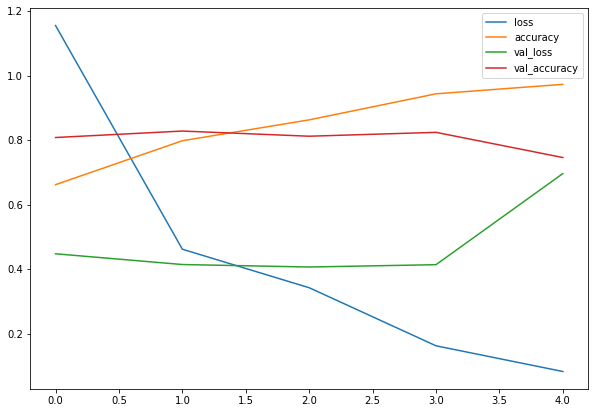

In [31]:
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

Hmm, kayıp eğrilerimize bakılırsa, modelimiz eğitim veri setine fazla uyuyor gibi görünüyor.

> 🔑 Not: Bir modelin doğrulama kaybı artmaya başladığında, büyük olasılıkla eğitim veri kümesine gereğinden fazla uyuyordur (overfitting). Bu, eğitim veri setindeki kalıpları çok iyi öğrendiği ve böylece görünmeyen verilere genelleme yapma yeteneğinin azalacağı anlamına gelir.

Modelimizin eğitim performansını daha fazla incelemek için doğruluk ve kayıp eğrilerini ayıralım.

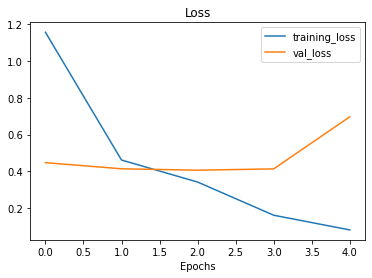

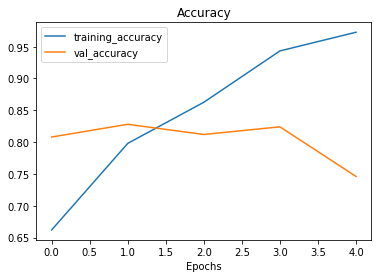

In [32]:
# Doğrulama ve eğitim verilerini ayrı ayrı çizme
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # loss (kayıp) eğriler
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # accuracy(doğruluk) eğrileri
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_4)

Bu iki eğri için ideal pozisyon birbirini takip etmektir. Herhangi bir şey varsa, doğrulama eğrisi eğitim eğrisinin biraz altında olmalıdır. Eğitim eğrisi ile doğrulama eğrisi arasında büyük bir boşluk varsa, modeliniz muhtemelen fazla uyuyor demektir.

In [33]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


### 6.Model Parametrelerini Ayarlayın

Bir makine öğrenimi modelinin takılması 3 adımda gerçekleşir:

0. Bir temel oluşturun.
1. Daha büyük bir modele overfitting taban çizgisini geçin.
2. overfitting azaltın.

Şimdiye kadar 0 ve 1 adımlarından geçtik.

Ve modelimize daha fazla uydurmaya çalışabileceğimiz birkaç şey daha var:

- Evrişim katmanlarının sayısını artırın.
- Evrişimli filtrelerin sayısını artırın.
- Düzleştirilmiş katmanımızın çıktısına başka bir yoğun katman ekleyin.

Ama bunun yerine yapacağımız şey, modelimizin eğitim eğrilerini birbiriyle daha iyi hizalamaya odaklanmak, başka bir deyişle 2. adımı atacağız.


**Overfitting'i azaltmak neden önemlidir?**

Bir model, eğitim verileri üzerinde çok iyi ve görünmeyen veriler üzerinde zayıf performans gösterdiğinde, onu gerçek dünyada kullanmak istiyorsak, bize pek faydası olmaz.

Diyelim ki bir pizza ve biftek yemek sınıflandırıcı uygulaması oluşturuyorduk ve modelimiz eğitim verilerimiz üzerinde çok iyi performans gösteriyor ancak kullanıcılar bunu denediğinde kendi yemek görüntülerinde çok iyi sonuçlar alamadılar, bu iyi bir deneyim mi?

Tam olarak değil...

Dolayısıyla, inşa edeceğimiz sonraki birkaç model için bir dizi parametreyi ayarlayacağız ve yol boyunca eğitim eğrilerini inceleyeceğiz.

Yani, 2 model daha inşa edeceğiz:

- Maksimum pooling'e sahip bir ConvNet
- Maksimum pooling'e ve veri artırma özelliğine sahip bir ConvNet

İlk model için bu yapıyı takip edeceğiz:
```
Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output
```
Hadi inşa edelim. model_4 ile aynı yapıya sahip olacak, ancak her evrişim katmanından sonra bir MaxPool2D() katmanı olacak.

In [34]:
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

Vayy, daha önce görmediğimiz başka bir katman tipimiz var.

Evrişimli katmanlar bir görüntünün özelliklerini öğrenirse, bu özelliklerden en önemlilerini bulmak olarak bir Max Pooling katmanını düşünebilirsiniz. Bunun bir örneğini birazdan göreceğiz.


In [35]:
# modeli derleme (model_4 gibi)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# modeli fit etme
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 195ms/step - loss: 0.5991 - accuracy: 0.6740 - val_loss: 0.4455 - val_accuracy: 0.8000
Epoch 2/5
47/47 [==============================] - 9s 181ms/step - loss: 0.4730 - accuracy: 0.7787 - val_loss: 0.4263 - val_accuracy: 0.8000
Epoch 3/5
47/47 [==============================] - 9s 193ms/step - loss: 0.4512 - accuracy: 0.7920 - val_loss: 0.3889 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 9s 190ms/step - loss: 0.4082 - accuracy: 0.8227 - val_loss: 0.3542 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 9s 190ms/step - loss: 0.3870 - accuracy: 0.8280 - val_loss: 0.3309 - val_accuracy: 0.8620


Tamam, maxPooling'li modelimiz (model_5) eğitim setinde daha kötü ama doğrulama setinde daha iyi performans gösteriyor gibi görünüyor.

Eğitim eğrilerini kontrol etmeden önce mimarisini kontrol edelim.


In [36]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

Her MaxPooling2D katmanındaki çıktı şekliyle burada neler olduğunu fark ettiniz mi?

Her seferinde yarı yarıya düşüyor. Bu MaxPooling2D katmanının her Conv2D katmanının çıktılarını alması ve "Ben sadece en önemli özellikleri istiyorum, geri kalanlardan kurtulun" demesidir.

pool_size parametresi ne kadar büyük olursa, maksimum havuzlama katmanı o kadar fazla özellikleri görüntüden çıkarır. Ancak, çok büyük ve model hiçbir şey öğrenemeyebilir.

Bu havuzlamanın sonuçları, toplam eğitilebilir parametrelerde (model_5'te 8.861 ve model_4'te 477.431) büyük bir azalma olarak görülmektedir.

Kayıp eğrilerini kontrol etme zamanı.


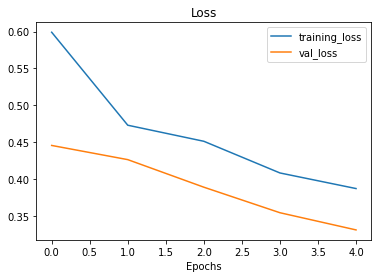

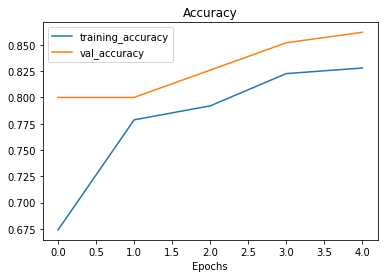

In [37]:
plot_loss_curves(history_5)

Güzel! Eğrilerin birbirine çok daha yakınlaştığını görebiliriz. Bununla birlikte, doğrulama kaybımız sona doğru artmaya başlıyor ve potansiyel olarak fazla uydurmaya yol açıyor.

Hile çantamıza girme ve overfitting'i önlemenin başka bir yöntemini, veri artırmayı denemenin zamanı geldi.

İlk olarak, kodla nasıl yapıldığını göreceğiz, sonra ne yaptığını tartışacağız.

Veri büyütmeyi uygulamak için ImageDataGenerator örneklerimizi yeniden başlatmamız gerekecek.


In [38]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                          rotation_range=0.2,# resmi biraz döndür
                          shear_range=0.2, # görüntüyü kırp
                          zoom_range=0.2,# resmi yakınlaştır
                          width_shift_range=0.2, # görüntü genişliği yollarını kaydır
                          height_shift_range=0.2, # görüntü yüksekliği yollarını kaydır
                          horizontal_flip=True) # görüntüyü yatay eksende çevir

train_datagen = ImageDataGenerator(rescale=1/255.) 
test_datagen = ImageDataGenerator(rescale=1/255.)

> 🤔 Soru: Veri büyütme nedir?

**Veri büyütme**, eğitim verilerimizi değiştirme, daha fazla çeşitliliğe sahip olmasına ve dolayısıyla modellerimizin daha genelleştirilebilir kalıpları öğrenmesine izin verme sürecidir. Değiştirmek, bir görüntünün dönüşünü ayarlamak, çevirmek, kırpmak veya benzeri bir şey anlamına gelebilir.

Bunu yapmak, bir modelin gerçek dünyada kullanılabileceği veri türünü simüle eder.

Bir pizza ve biftek uygulaması oluşturuyorsak, kullanıcılarımızın çektiği resimlerin tümü eğitim verilerimize benzer kurulumlarda olmayabilir. Veri büyütmeyi kullanmak, overfitting'i önlemenin ve dolayısıyla modelimizi daha genelleştirilebilir hale getirmenin başka bir yolunu sunar.

> 🔑 Not: Veri büyütme genellikle yalnızca eğitim verileri üzerinde gerçekleştirilir. ImageDataGenerator yerleşik veri büyütme parametrelerini kullanarak, görüntülerimiz dizinlerde olduğu gibi bırakılır, ancak modele yüklendiğinde rastgele manipüle edilir.

In [39]:
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='binary',
                      shuffle=False)

print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='binary',
                      shuffle=False)

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                      target_size=(224, 224),
                      batch_size=32,
                      class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


Veri büyütme hakkında konuşmaktan daha iyi, onu görmeye ne dersiniz?

(mottomuzu hatırlıyor musun? görselleştir, görselleştir, görselleştir...)


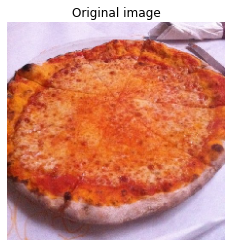

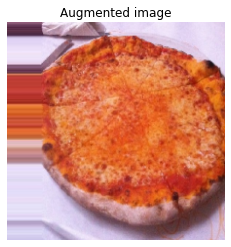

In [40]:
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() 

# orjinal ile tahmin edilen görseli karşılaştırma
random_number = random.randint(0, 32)
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Orjinal ve artırılmış görsellerin bir örneğini inceledikten sonra, eğitim görselleri üzerinde bazı örnek dönüşümleri görmeye başlayabilirsiniz.

Bazı artırılmış görüntülerin orijinal görüntünün hafifçe çarpık sürümleri gibi göründüğüne dikkat edin. Bu, modelimizin, gerçek dünya görüntülerini kullanırken genellikle olduğu gibi, mükemmel olmayan görüntülerdeki kalıpları denemek ve öğrenmek zorunda kalacağı anlamına gelir.

> 🤔 Soru: Veri büyütmeyi kullanmalı mıyım? Ve ne kadar arttırmalıyım?

Veri büyütme, bir modelin overfitting olmasını önlemenin bir yoludur. Modeliniz gereğinden fazla overfitting oluyorsa (örneğin, doğrulama kaybı artmaya devam ediyorsa), veri büyütmeyi kullanmayı denemek isteyebilirsiniz.

Ne kadar veri artırılacağına gelince, bunun için belirlenmiş bir uygulama yok. ImageDataGenerator sınıfındaki seçeneklere göz atmak ve kullanım durumunuzdaki bir modelin bazı veri artırmalarından nasıl yararlanabileceğini düşünmek en iyisidir.

Şimdi artırılmış veriye sahibiz, üzerine bir model yerleştirmeye çalışalım ve eğitimi nasıl etkilediğini görelim.

Model_5 ile aynı modeli kullanacağız.

In [ ]:
# bir model oluşturma (model_5 gibi)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), 
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# modeli derleme
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# modeli fit etme
history_6 = model_6.fit(train_data_augmented, # artırılmış eğitim verilerine değiştirildi
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 459ms/step - loss: 0.7113 - accuracy: 0.4993 - val_loss: 0.6788 - val_accuracy: 0.5100
Epoch 2/5
47/47 [==============================] - 22s 463ms/step - loss: 0.6920 - accuracy: 0.4993 - val_loss: 0.6626 - val_accuracy: 0.6500
Epoch 3/5
47/47 [==============================] - 22s 478ms/step - loss: 0.6894 - accuracy: 0.6053 - val_loss: 0.6055 - val_accuracy: 0.7640
Epoch 4/5
47/47 [==============================] - 21s 450ms/step - loss: 0.6254 - accuracy: 0.6960 - val_loss: 0.5089 - val_accuracy: 0.8060
Epoch 5/5
32/47 [===================>..........] - ETA: 6s - loss: 0.6023 - accuracy: 0.6863

> 🤔 Soru: Modelimiz başlangıçta eğitim setinde neden çok iyi sonuçlar alamadı?

Bunun nedeni, train_data_augmented'i oluşturduğumuzda, shuffle=False kullanarak veri karıştırmayı kapatmış olmamızdır; bu, modelimizin bir seferde yalnızca tek bir tür görüntüden oluşan bir toplu iş gördüğü anlamına gelir.

Örneğin, pizza sınıfı birinci sınıf olduğu için ilk yüklenir. Böylece performansı her iki sınıftan ziyade sadece tek bir sınıfta ölçülür. Doğrulama verileri performansı, karıştırılmış veriler içerdiğinden sürekli olarak iyileşir.

Gösteri amacıyla yalnızca shuffle=False ayarladığımızdan (böylece aynı artırılmış ve büyütülmemiş görüntüyü çizebiliriz), gelecekteki veri oluşturucularda shuffle=True ayarını yaparak bunu düzeltebiliriz.

Ayrıca, artırılmış verilerle eğitim alırken her bir dönemin, artırılmamış verilerle eğitime kıyasla daha uzun sürdüğünü fark etmiş olabilirsiniz (dönem başına ~25sn ve dönem başına ~10sn).

Bunun nedeni, ImageDataGenerator örneğinin, modele yüklenirken verileri büyütmesidir. Bunun yararı, orijinal görüntüleri değiştirmeden bırakmasıdır. Dezavantajı, onları yüklemenin daha uzun sürmesidir.

> 🔑 Not: Veri kümesi manipülasyonunu hızlandırmanın olası bir yöntemi,[ TensorFlow'un paralel okumalarına ve arabelleğe alınmış önceliklendirme](https://www.tensorflow.org/tutorials/images/data_augmentation) seçeneklerine bakmak olabilir.

In [ ]:
plot_loss_curves(history_6)

Doğrulama kaybı eğrimiz doğru yönde ilerliyor gibi görünüyor, ancak biraz ürkek (en ideal kayıp eğrisi çok keskin değil, yumuşak bir iniş, ancak tamamen pürüzsüz bir kayıp eğrisi bir peri masalına eşdeğerdir).

Arttırılmış verileri karıştırdığımızda ne olacağını görelim.

In [ ]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        shuffle=True)

In [ ]:
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_7 = model_7.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        verbose=0)

plot_loss_curves(history_7)

model_7 ile eğitim veri kümesindeki performansın model_6 ile karşılaştırıldığında neredeyse anında nasıl arttığına dikkat edin. Bunun nedeni, eğitim verilerini, flow_from_directory yönteminde shuffle=True parametresini kullanarak modele geçirirken karıştırmış olmamızdır.

Bu, modelin her partide hem pizza hem de biftek görüntülerinin örneklerini görebildiği ve sırayla tek türden değil, her iki görüntüden öğrendiklerini değerlendirebildiği anlamına gelir.

Ayrıca, kayıp eğrilerimiz karıştırılmış verilerle biraz daha pürüzsüz görünüyor (history_6 ile history_7'yi karşılaştırarak).

7.Tatmin Olana Kadar Tekrarlayın

Veri kümemizde zaten birkaç model eğittik ve şu ana kadar oldukça iyi performans gösteriyorlar.

Temel çizgimizi çoktan aştığımız için modelimizi geliştirmeye devam etmek için deneyebileceğimiz birkaç şey var:

- Model katmanlarının sayısını artırın (örneğin, daha fazla evrişim katmanı ekleyin).
- Her evrişim katmanındaki filtre sayısını artırın (örn. 10'dan 32'ye, 64'e veya 128'e, bu sayılar da sabit değildir, genellikle deneme yanılma yoluyla bulunurlar).
- Daha uzun süre training yapın (daha fazla dönem).
- İdeal bir öğrenme oranı (learning_rate) bulma.
- Daha fazla veri alın (modele öğrenmesi için daha fazla fırsat verin).
- Başka bir görüntü modelinin öğrendiklerinden yararlanmak için aktarım öğrenimini kullanın ve bunu kendi kullanım durumumuza göre ayarlayın.

Model geliştirme sırasında bu ayarların her birinin (son ikisi hariç) ayarlanması genellikle hiperparametre ayarı olarak adlandırılır.

Hiperparametre ayarını, en sevdiğiniz yemeği pişirmek için fırınınızdaki ayarları yapmaya benzetebilirsiniz. Fırınınız sizin için pişirmenin çoğunu yapsa da, ısıyı ayarlayarak buna yardımcı olabilirsiniz.

Başladığımız yere geri dönelim ve orijinal modelimizi deneyelim:

In [ ]:
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), 
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

> 🔑 Not: Model_8'i oluşturmak için model_1 ile karşılaştırıldığında biraz farklı kodlar kullandığımızı fark etmiş olabilirsiniz. Bunun nedeni, daha önce yaptığımız içe aktarmalar, örneğin tensorflow.keras.layers'dan içe aktarma Conv2D, yazmamız gereken kod miktarını azaltır. Kodlar farklı olsa da mimariler aynı.

In [ ]:
model_1.summary()

In [ ]:
model_8.summary()

Şimdi TinyVGG modelimizin performansını kontrol edelim.

In [ ]:
# TinyVGG model performansına göz atın
plot_loss_curves(history_8)

In [ ]:
# Bu eğitim eğrisi yukarıdakine kıyasla nasıl görünüyor?
plot_loss_curves(history_1)

Hmm, eğitim eğrilerimiz iyi görünüyor, ancak modelimizin eğitim ve test setlerindeki performansı önceki modele göre pek gelişmedi.

Eğitim eğrilerine bir kez daha baktığımızda, biraz daha uzun süre (daha fazla dönem) eğitirsek modelimizin performansı artabilir gibi görünüyor.


### Eğitimli Modelimiz ile Tahmin Yapmak

Onunla tahmin yapamıyorsanız, eğitimli bir model ne işe yarar? Gerçekten test etmek için kendi resimlerimizden birkaçını yükleyeceğiz ve modelin nasıl gittiğini göreceğiz. Öncelikle kendimize sınıf isimlerini hatırlatalım ve üzerinde test edeceğimiz görsele bakalım.

In [ ]:
# Çalıştığımız Sınıflar
print(class_names)